<a href="https://colab.research.google.com/github/lacykaltgr/quant/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
import pandas as pd
import numpy as np

In [3]:
quant_folder_location = "/content/drive/MyDrive/quant"
weather_prepared_file_path = quant_folder_location + "/weather_df.csv"
county_location_file_path = quant_folder_location + "/agri/minnesota_county_location.csv"
county_agr_prod_file_path = quant_folder_location + "/agri/minnesota_county_yearly_agricultural_production.csv"
station_location_file_path = quant_folder_location + "/weather/minnesota_station_location.csv"

def station_weather_fp(station_name):
  return quant_folder_location + "/weather/minnesota_daily/" + str(station_name) + ".csv"

# Prepare weather data


In [4]:
#átugrási lehetőség
weather_df = pd.read_csv(weather_prepared_file_path)

<ipython-input-4-b90705cc2f0b>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv(weather_prepared_file_path)


In [6]:
station_location_df = pd.read_csv(station_location_file_path)

station_weather_df_list = []
station_codes = np.unique(station_location_df.Code)
for code in station_codes:
  try:
      station_df = pd.read_csv(station_weather_fp(code), header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list.append(station_df)
  except:
      station_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

In [ ]:
from dateutil.relativedelta import relativedelta
import math

for station in station_weather_df_list:
  station["date"] = pd.to_datetime(station["date"])
  station["min"] = station["min"].interpolate(method="linear", limit=21)
  station["max"] = station["max"].interpolate(method="linear", limit=21)
  for index, record in station.iterrows():
    if math.isnan(record["min"]):
      for i in range(index, index+15*365+1, 365):
        if not math.isnan(station.iloc[i+365]["min"]):
          station.loc[index, "min"] = station.iloc[i+365]["min"]
          break
        else: 
          if not math.isnan(station.iloc[i-365]["min"]):
            station.loc[index, "min"] = station.iloc[i-365]["min"]
            break
    if math.isnan(record["max"]):
      for i in range(index, index+15*365+1, 365):
        if not math.isnan(station.iloc[i+365]["max"]):
          station.loc[index, "max"] = station.iloc[i+365]["max"]
          break
        else:
          if not math.isnan(station.iloc[i-365]["max"]):
            station.loc[index, "max"] = station.iloc[i-365]["max"]
            break
    if math.isnan(record["rain"]):
      i = index+365
      while i < len(station):
        if not math.isnan(station.iloc[i]["rain"]):
          station.loc[index, "rain"] = station.iloc[i]["rain"]
          break
        i += 365

In [ ]:
for i, (station_data, code) in enumerate(zip(station_weather_df_list, station_codes)):
  lat = station_location_df[station_location_df["Code"] == code ].Latitude.values[0]
  lon = station_location_df[station_location_df["Code"] == code ].Longitude.values[0]
  station_weather_df_list[i] = station_data.assign(code = code, lat = lat, lon = lon)

combined_weather_df = pd.concat(station_weather_df_list, axis=0)

In [ ]:
combined_weather_df["rain"] = combined_weather_df["rain"].fillna(0)

In [ ]:
combined_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603227 entries, 0 to 53
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    603227 non-null  datetime64[ns]
 1   avg     507300 non-null  float64       
 2   min     603227 non-null  float64       
 3   max     603227 non-null  float64       
 4   rain    603227 non-null  float64       
 5   code    603227 non-null  object        
 6   lat     603227 non-null  float64       
 7   lon     603227 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 41.4+ MB


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

no_missing_weather_df = combined_weather_df[combined_weather_df["avg"].notnull()]
no_missing_weather_train_df = no_missing_weather_df.drop(["code", "rain"], axis=1)
no_missing_weather_train_df['year'] = no_missing_weather_train_df['date'].dt.year
no_missing_weather_train_df['month'] = no_missing_weather_train_df['date'].dt.month
no_missing_weather_train_df['day'] = no_missing_weather_train_df['date'].dt.day
no_missing_weather_train_df = no_missing_weather_train_df.drop("date", axis=1)

X_fill_avg = no_missing_weather_train_df.drop("avg", axis=1)
y_fill_avg = no_missing_weather_train_df["avg"]
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_fill_avg, y_fill_avg, test_size=0.1)
evaluation = [(X_avg_train, y_avg_train), (X_avg_test, y_avg_test)]

model = XGBRegressor(early_stopping_rounds=300)
model.fit(X_avg_train, y_avg_train, eval_set=evaluation, verbose=1)

[0]	validation_0-rmse:9.68208	validation_1-rmse:9.69098
[1]	validation_0-rmse:6.82052	validation_1-rmse:6.82759
[2]	validation_0-rmse:4.82529	validation_1-rmse:4.83083
[3]	validation_0-rmse:3.44214	validation_1-rmse:3.44614
[4]	validation_0-rmse:2.49527	validation_1-rmse:2.49741
[5]	validation_0-rmse:1.85877	validation_1-rmse:1.85882
[6]	validation_0-rmse:1.44355	validation_1-rmse:1.44099
[7]	validation_0-rmse:1.18621	validation_1-rmse:1.18025
[8]	validation_0-rmse:1.03430	validation_1-rmse:1.02498
[9]	validation_0-rmse:0.94939	validation_1-rmse:0.93748
[10]	validation_0-rmse:0.90244	validation_1-rmse:0.88965
[11]	validation_0-rmse:0.87769	validation_1-rmse:0.86382
[12]	validation_0-rmse:0.86409	validation_1-rmse:0.84955
[13]	validation_0-rmse:0.85614	validation_1-rmse:0.84124
[14]	validation_0-rmse:0.85112	validation_1-rmse:0.83590
[15]	validation_0-rmse:0.84791	validation_1-rmse:0.83261
[16]	validation_0-rmse:0.84525	validation_1-rmse:0.82967
[17]	validation_0-rmse:0.84347	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
missing_avg_weather_df = combined_weather_df[combined_weather_df["avg"].isnull()]
missing_avg_weather_prediction_X_df = missing_avg_weather_df.drop(["avg", "code", "rain"], axis=1)
missing_avg_weather_prediction_X_df['year'] = missing_avg_weather_prediction_X_df['date'].dt.year
missing_avg_weather_prediction_X_df['month'] = missing_avg_weather_prediction_X_df['date'].dt.month
missing_avg_weather_prediction_X_df['day'] = missing_avg_weather_prediction_X_df['date'].dt.day
missing_avg_weather_prediction_X_df = missing_avg_weather_prediction_X_df.drop("date", axis=1)

missing_avg_weather_prediction_y_df = model.predict(missing_avg_weather_prediction_X_df)
missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df

<ipython-input-86-b35569beda65>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df


In [ ]:
missing_avg_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95927 entries, 0 to 6300
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    95927 non-null  datetime64[ns]
 1   avg     95927 non-null  float32       
 2   min     95927 non-null  float64       
 3   max     95927 non-null  float64       
 4   rain    95927 non-null  float64       
 5   code    95927 non-null  object        
 6   lat     95927 non-null  float64       
 7   lon     95927 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(5), object(1)
memory usage: 6.2+ MB


In [ ]:
weather_df = pd.concat([missing_avg_weather_df, no_missing_weather_df], axis=0)

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603227 entries, 0 to 53
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    603227 non-null  datetime64[ns]
 1   avg     603227 non-null  float64       
 2   min     603227 non-null  float64       
 3   max     603227 non-null  float64       
 4   rain    603227 non-null  float64       
 5   code    603227 non-null  object        
 6   lat     603227 non-null  float64       
 7   lon     603227 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 41.4+ MB


In [ ]:
filename = 'weather_df.csv'
weather_df.to_csv('/content/drive/MyDrive/quant' + filename)

In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [20]:
weather_stations = []
for code in station_codes:
  station = dict()
  station["code"] = code
  station["lat"] = station_location_df[station_location_df["Code"] == code]["Latitude"].values[0]
  station["lon"] = station_location_df[station_location_df["Code"] == code]["Longitude"].values[0]

  weather_data = weather_df[weather_df['code'] == code].drop(["code", "Unnamed: 0", "lat", "lon"], axis=1)
  station["weather_daily"] = weather_data

  weather_data["date"] = pd.to_datetime(weather_data["date"])
  weather_data["year"] = weather_data['date'].dt.year
  weather_data['week'] = weather_data['date'].dt.isocalendar().week
  weather_data = weather_data.drop("date", axis=1)
  weekly_stats = weather_data.groupby(['year', 'week']).agg({'min': ['mean', 'std'], 'max': ['mean', 'std'], 'avg': ['mean', 'std'], 'rain': ['mean', 'std']})
  weekly_stats = weekly_stats.reset_index()
  weekly_stats.columns = ['year', 'week', 'min_mean', 'min_std', 'max_mean', 'max_std', 'avg_mean', 'avg_std', 'rain_mean', 'rain_std']

  station["weather_weekly"] = weekly_stats
  weather_stations.append(station)
len(weather_stations)

97

In [22]:
weather_stations[0]

{'code': '72644',
 'lat': 43.9,
 'lon': -92.5,
 'weather_daily':              date   avg   min   max  rain  year  week
 95927  1973-01-01 -12.2 -16.1  -8.9   0.0  1973     1
 95928  1973-01-02  -6.3 -13.9  -0.6   0.0  1973     1
 95929  1973-01-03  -3.6 -12.2  -1.7  19.6  1973     1
 95930  1973-01-04 -18.7 -22.8 -12.2   0.0  1973     1
 95931  1973-01-05 -23.9 -27.8 -19.4   0.0  1973     1
 ...           ...   ...   ...   ...   ...   ...   ...
 113541 2022-06-13  20.7  18.0  25.0  22.5  2022    24
 113542 2022-06-14  27.9  22.0  35.0   0.0  2022    24
 113543 2022-06-15  19.7  17.2  24.4  19.3  2022    24
 113544 2022-06-16  22.5  17.4  27.3   0.0  2022    24
 113545 2022-06-17  20.4  15.4  25.4   0.0  2022    24
 
 [17619 rows x 7 columns],
 'weather_weekly':       year  week   min_mean   min_std   max_mean   max_std   avg_mean  \
 0     1973     1 -22.637500  7.546984 -12.837500  8.395056 -17.362500   
 1     1973     2 -20.371429  7.452229 -10.000000  7.626926 -14.942857   
 2     

# Prepare crop data

In [ ]:
county_locations_df = pd.read_csv(county_location_file_path)
county_agr_prod_df = pd.read_csv(county_agr_prod_file_path, decimal=',')

In [ ]:
county_agr_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56268 entries, 0 to 56267
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Year                          56268 non-null  int64 
 1   County                        56268 non-null  object
 2   Commodity                     56268 non-null  object
 3   Crop                          56268 non-null  object
 4   ACRES HARVESTED               52674 non-null  object
 5   PRODUCTION, MEASURED IN BU    33231 non-null  object
 6   YIELD, MEASURED IN BU / ACRE  33232 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.0+ MB


In [ ]:
county_agr_prod_df = county_agr_prod_df.rename(
    columns={'ACRES HARVESTED': 'acres', 
             'PRODUCTION, MEASURED IN BU': 'production', 
             'YIELD, MEASURED IN BU / ACRE': 'yield'})
county_agr_prod_df['acres'] = pd.to_numeric(county_agr_prod_df['acres'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['production'] = pd.to_numeric(county_agr_prod_df['production'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['yield'] = pd.to_numeric(county_agr_prod_df['yield'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df = county_agr_prod_df[county_agr_prod_df['acres'].notnull() | county_agr_prod_df['production'].notnull() | county_agr_prod_df['yield'].notnull()]

corn_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "CORN, GRAIN"] #| county_agr_prod_df["Crop"] == "CORN, SILAGE"]
oat_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "OATS"]
soybean_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "SOYBEANS"]

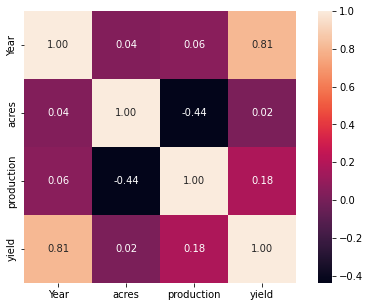

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = corn_df

plot = plot[plot['acres'].notnull() & plot['production'].notnull() & plot['yield'].notnull()]
numeric_columns = plot.select_dtypes(include=['int64', 'float64']).columns

cm = np.corrcoef(plot[numeric_columns].values.T)
fig = plt.gcf()
fig.set_size_inches(8, 5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_columns.values, xticklabels=numeric_columns.values)

In [ ]:
county_locations_df['county_name'] = county_locations_df['county_name'].apply(lambda x: ' '.join(x.split()[:-1]).upper())
county_locations_df['county_name'] = county_locations_df['county_name'].str.replace('SAINT LOUIS', 'ST. LOUIS')
corn_df_extended = pd.merge(corn_df, county_locations_df, how='outer', left_on='County', right_on='county_name')

In [ ]:
corn_df_clean = corn_df_extended.drop(["County", "Commodity", "Crop", "county_name", "capital_name", "production", "acres"], axis=1)
corn_df_clean = corn_df_clean[corn_df_clean["yield"].notnull() & corn_df_clean["county_latitude"].notnull() & corn_df_clean["county_longitude"].notnull()]

In [ ]:
corn_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 5014
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              5014 non-null   float64
 1   yield             5014 non-null   float64
 2   county_latitude   5014 non-null   float64
 3   county_longitude  5014 non-null   float64
dtypes: float64(4)
memory usage: 195.9 KB


In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602679 entries, 0 to 53
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    602679 non-null  datetime64[ns]
 1   avg     602679 non-null  float64       
 2   min     602679 non-null  float64       
 3   max     602679 non-null  float64       
 4   rain    602679 non-null  float64       
 5   lat     602679 non-null  float64       
 6   lon     602679 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 36.8 MB


In [ ]:
for year_yield in corn_df:
  count_lat = year_yield["county_latitude"]

In [ ]:
corn_df_clean.iloc[0]["county_latitude"]

46.5714822

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    # Convert latitude and longitude to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the differences between the two points
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the haversine of half the differences
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    # Calculate the great circle distance
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance in kilometers
    dist = R * c

    return dist

In [ ]:
county_lat = corn_df_clean.iloc[0]["county_latitude"]
county_lon = corn_df_clean.iloc[0]["county_longitude"]
min_d = []
for index, county in corn_df_clean.iterrows():
  distances = []
  county_lat = county["county_latitude"]
  county_lon = county["county_longitude"]
  for i, station in station_location_df.iterrows():
    station_lat = station['Latitude']
    station_lon = station['Longitude']
    lat_diff = county_lat - station_lat
    lon_diff = county_lon - station_lon
    distances.append(distance(station_lat, station_lon, county_lat, county_lon))
  min_d.append(min(distances))

[7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 7.77735500962914,
 15.298184352082307,
 15.298184352082307,
 15.2981

In [ ]:
station_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Code       97 non-null     object 
 1   Latitude   97 non-null     float64
 2   Longitude  97 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.4+ KB
